In [ ]:
cd /content/drive/MyDrive/Thesis_Organized

/content/drive/MyDrive/Thesis_Organized


In [ ]:
import os
from tqdm import tqdm
main_dir = os.getcwd()

In [ ]:
# importing
from Detectron2.detectron_conf import *
Detectron2_cfg["Momentum"], Detectron2_cfg["base_lr"]

(0.9, 0.00016)

In [ ]:
# check for GPU availability

!nvidia-smi

Wed Sep 20 10:42:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
# Setups
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
import detectron2
# from detectron2.utils.logger import setup_logger
# setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import os

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, Data_cfg["Coco_labels_train_dir"], os.path.join(Data_cfg["cropped_Images_dir"], "Train"))
register_coco_instances("my_dataset_test", {}, Data_cfg["Coco_labels_test_dir"], os.path.join(Data_cfg["cropped_Images_dir"], "Test"))
register_coco_instances("my_dataset_val", {}, Data_cfg["Coco_labels_val_dir"], os.path.join(Data_cfg["cropped_Images_dir"], "Val"))

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced


    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [ ]:
from detectron2.data import DatasetMapper, build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.data.transforms import RandomApply, RandomBrightness, RandomRotation, RandomFlip, RandomCrop, RandomContrast
from detectron2.config import CfgNode
from detectron2.solver.build import get_default_optimizer_params, maybe_add_gradient_clipping



class CustomTrainer(DefaultTrainer):
    """
    Custom Trainer deriving from the "DefaultTrainer"

    Overloads build_hooks to add a hook to calculate loss on the test set during training.
    """

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(
            20, # Frequency of calculation - every 20 iterations here
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg, True)
            )
        ))

        return hooks

#     "@classmethod"
#     def build_train_loader(cls, cfg):
#         mapper = DatasetMapper(cfg, is_train=True, augmentations=[
#             RandomApply(RandomBrightness(Augmentation_cfg["RandomBrightness"][0],Augmentation_cfg["RandomBrightness"][1]),Augmentation_cfg["RandomBrightness"][2]),
#             RandomApply(RandomRotation(angle = [Augmentation_cfg["RandomRotation"][0],Augmentation_cfg["RandomRotation"][1]]),Augmentation_cfg["RandomRotation"][2]),
#             RandomApply(RandomFlip(),Augmentation_cfg["RandomFlip"][0]),
#             RandomApply(RandomCrop(crop_type = "relative", crop_size = (Augmentation_cfg["RandomCrop"][0],Augmentation_cfg["RandomCrop"][1])),Augmentation_cfg["RandomCrop"][2]),
#             RandomApply(RandomContrast(Augmentation_cfg["RandomContrast"][0],Augmentation_cfg["RandomContrast"][1]),Augmentation_cfg["RandomContrast"][2])
#             ])
#         return build_detection_train_loader(cfg, mapper=mapper)


#     "@classmethod"
#     def build_optimizer(cls, cfg: CfgNode, model: torch.nn.Module) -> torch.optim.Optimizer:
#         """
#         Build an optimizer from config.
#         """
#         params = get_default_optimizer_params(
#             model,
#             base_lr=cfg.SOLVER.BASE_LR,
#             weight_decay_norm=cfg.SOLVER.WEIGHT_DECAY_NORM,
#             bias_lr_factor=cfg.SOLVER.BIAS_LR_FACTOR,
#             weight_decay_bias=cfg.SOLVER.WEIGHT_DECAY_BIAS,
#         )
#         return maybe_add_gradient_clipping(cfg, torch.optim.AdamW)(
#             params,
#             lr=cfg.SOLVER.BASE_LR,
#             weight_decay=cfg.SOLVER.WEIGHT_DECAY,
#         )

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "./Detectron2/Test_results/SGD0.99_001_00_3x101"
cfg.merge_from_file(model_zoo.get_config_file(MODELS_LIST[1]))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.SOLVER.MOMENTUM = 0.99 #Detectron2_cfg["Momentum"]
cfg.SOLVER.CHECKPOINT_PERIOD = 200  # The network takes a checkpoint once it finishes of every 200 iterations
# cfg.TEST.EVAL_PERIOD = 20
cfg.DATALOADER.NUM_WORKERS = NUM_WORKERS
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODELS_LIST[1])  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = IMS_PER_BATCH  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.001 # Detectron2_cfg["base_lr"]  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE_PER_IMAGE  # The "RoIHead batch size". 128 is faster, and good enough for this dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  # only has one class (Track). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[09/20 13:40:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
import json

with open(os.path.join(cfg.OUTPUT_DIR, "metrics.json"), 'r') as handle:
    json_data = [json.loads(line) for line in handle]

In [ ]:
training_loss = []
validation_loss = []
iteration = []

for i in json_data:
  if "iteration" in i.keys():
    iteration.append(i["iteration"])
  else:
    iteration.append(iteration[-1])

  if "total_loss" in i.keys():
    training_loss.append(i["total_loss"])
  else:
    training_loss.append(training_loss[-1])

  if "validation_loss" in i.keys():
    validation_loss.append(i["validation_loss"])
  else:
    validation_loss.append(validation_loss[-1])

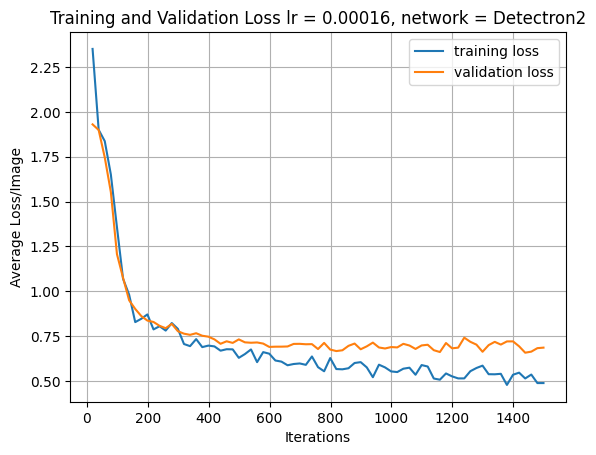

In [ ]:
import matplotlib.pyplot as plt


plt.plot(iteration, training_loss, label = "training loss")
plt.plot(iteration, validation_loss, label = "validation loss")
plt.xlabel("Iterations")
plt.ylabel("Average Loss/Image")
# plt.ylim([0, 2.5])
plt.title(f"Training and Validation Loss lr = {Detectron2_cfg['base_lr']}, network = Detectron2")
plt.legend()
plt.grid()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "losses.png"))
plt.show()

## Testing

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[09/20 13:46:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./Detectron2/Test_results/SGD0.99_001_00_3x101/model_final.pth ...


In [ ]:
import pandas as pd

data_path = Data_cfg["annotations_path"]
df = pd.read_csv(data_path).drop(columns = ["Unnamed: 0"])
df.head()

,id,name,track,z_order,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,folder,bbox_x,bbox_y,bbox_width,bbox_height,segmentation
0,0,L1Ap5_1-1-109.png,Track1,0,411.65,248.47,312.63,149.45,223.32,36.45,Train,209.48,254.64,217.19,239.21,"[217.19, 27.01, 215.91, 28.29, 214.62, 29.58, ..."
1,0,L1Ap5_1-1-109.png,Track2,0,384.92,256.98,339.97,263.66,406.79,249.08,Train,327.71,237.92,93.82,43.73,"[399.68, 239.21, 398.4, 240.5, 397.11, 240.5, ..."
2,1,L1Ap5_1-1-142.png,Track1,0,567.18,283.10,495.49,275.20,440.15,264.27,Val,427.96,218.63,151.65,48.87,"[435.67, 253.36, 434.38, 254.64, 433.1, 254.64..."
3,1,L1Ap5_1-1-142.png,Track2,0,316.88,223.56,243.37,181.04,130.37,128.18,Val,116.95,279.08,214.62,124.75,"[127.23, 117.03, 125.95, 118.32, 124.66, 118.3..."
4,1,L1Ap5_1-1-142.png,Track3,0,364.27,251.51,356.98,269.74,347.26,291.61,Val,332.86,210.92,46.27,66.88,"[355.99, 243.07, 354.7, 244.35, 354.7, 245.64,..."


In [ ]:
df.isna().sum()

id               0
name             0
track            0
z_order          0
p1_x             0
p1_y             0
p2_x             0
p2_y             0
p3_x             0
p3_y             0
folder           0
bbox_x          14
bbox_y          14
bbox_width      14
bbox_height     14
segmentation    14
dtype: int64

In [ ]:
df.groupby("folder").count()

,id,name,track,z_order,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,bbox_x,bbox_y,bbox_width,bbox_height,segmentation
folder,,,,,,,,,,,,,,,
Test,291,291,291,291,291,291,291,291,291,291,289,289,289,289,289
Train,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2425,2425,2425,2425,2425
Val,324,324,324,324,324,324,324,324,324,324,321,321,321,321,321


In [ ]:
def evaluate_instance(gt_lst, outputs):

  instances = len(gt_lst)
  predictions = outputs.shape[0]
  eval = np.ones((instances, predictions)) * -1

  for i in range(instances):
    for j in range(predictions):
      intersection = np.logical_and(gt_lst[i], outputs[j, :, :]).sum()
      union = np.logical_or(gt_lst[i], outputs[j, :, :]).sum()
      eval[i, j] = intersection/union
  return eval

In [ ]:
from tqdm import tqdm

test = df[df.folder == "Val"].copy()
test = test.reset_index().drop(columns = ["index"])
output_dict = {}

for image in tqdm(np.unique(test.name.values)):
  temp = test[test.name == image].copy()
  im_dir = os.path.join(main_dir, Data_cfg["cropped_Images_dir"], temp.folder.values[0], image)
  im = cv2.imread(im_dir)
  outputs = predictor(im)
  outputs = outputs["instances"].pred_masks.to("cpu").numpy()
  gt_lst = []
  for instance in temp.track:
    gt_dir = os.path.join(Data_cfg["GT_Images_dir"], temp.folder.values[0], temp.name.values[0][:-4], instance + ".png")
    gt = cv2.imread(gt_dir)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    gt = cv2.resize(gt, (658, 517), interpolation = cv2.INTER_AREA)
    gt = gt.astype("bool")
    gt_lst.append(gt)

  output_dict[image] = evaluate_instance(gt_lst, outputs)

100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


In [ ]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open(os.path.join(cfg.OUTPUT_DIR, "test_results.p"), 'wb') as fp:
    pickle.dump(output_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open(os.path.join(cfg.OUTPUT_DIR, "test_results.p"), 'rb') as fp:
    output_dict = pickle.load(fp)

In [ ]:
import numpy as np

def FP_FN_0(output_dict: dict):

  out = 0
  for img in tqdm(output_dict.keys()):
    con_mat_shape = output_dict[img].shape
    if con_mat_shape[0] != con_mat_shape[1]:
      continue
    else:
      tps = output_dict[img] > 0.5
      if (tps.sum(axis = 0) == np.ones(con_mat_shape[0])).all() and (tps.sum(axis = 1) == np.ones(con_mat_shape[0])).all():
        out += 1
  return out

def TP(output_dict: dict):

    out = 0
    for img in tqdm(output_dict.keys()):
      cf_mat = output_dict[img].copy()
      con_mat_shape = cf_mat.shape
      for i in range(con_mat_shape[1]):
        idx = cf_mat[:, i].argmax()
        if cf_mat[idx, i] > 0.5:
          out += 1
          cf_mat[idx, :] = 0
          cf_mat[:, i] = 0
    return out

def FP(output_dict: dict):

  out = 0
  for img in tqdm(output_dict.keys()):
      cf_mat = output_dict[img].copy()
      con_mat_shape = cf_mat.shape
      for i in range(con_mat_shape[1]):
        if (cf_mat[:, i] > 0.5).sum() == 0:
          out += 1
  return out

def TP_0(output_dict: dict):

  out = 0
  for img in tqdm(output_dict.keys()):
      cf_mat = output_dict[img].copy()
      con_mat_shape = cf_mat.shape
      flag = True
      for i in range(con_mat_shape[1]):
        if (cf_mat[:, i] > 0.5).sum() != 0:
          flag = False
      if flag:
        out += 1
  return out

In [ ]:
results_dict = {
    "FP_FN_0": FP_FN_0(output_dict),
    "TP": TP(output_dict),
    "FP": FP(output_dict),
    "TP_0": TP_0(output_dict)
}

results = pd.DataFrame(results_dict, index = ["results"])
results.to_csv(os.path.join(cfg.OUTPUT_DIR, "results.csv"))
results

100%|██████████| 100/100 [00:00<00:00, 46650.03it/s]


,FP_FN_0,TP,FP,TP_0
results,61,274,35,0


In [ ]:
print(f"Recall: {(results.TP/(results.TP+results.FP)).values[0]}, Precision: {(results.TP/321).values[0]}")

Recall: 0.8867313915857605, Precision: 0.8535825545171339


In [ ]:
import numpy as np
p = np.arange(0,1,0.01)

<ipython-input-6-6093475c2b87>:2: RuntimeWarning: divide by zero encountered in divide
  q = p*np.log2(1/p)+(1-p)*np.log2(1/(1-p))
<ipython-input-6-6093475c2b87>:2: RuntimeWarning: invalid value encountered in multiply
  q = p*np.log2(1/p)+(1-p)*np.log2(1/(1-p))


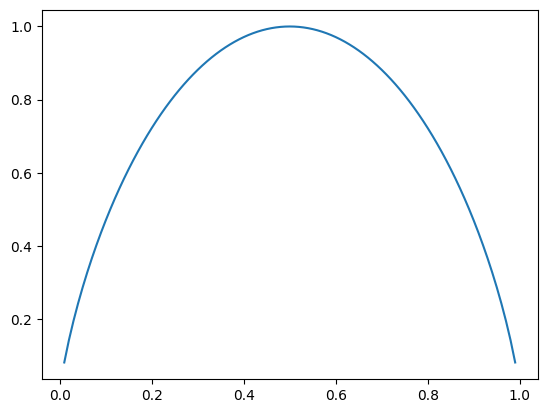

In [ ]:
import matplotlib.pyplot as plt
q = p*np.log2(1/p)+(1-p)*np.log2(1/(1-p))
plt.plot(p,q)
plt.grid()
plt.show()